https://www.tensorflow.org/tutorials/images/classification?hl=fr

In [ ]:
pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7395 sha256=423dcd886f62507701dd3c60bd3b4156be92e7c4ad4a69d6c8d4531d30ac3933
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [ ]:
pip list

In [ ]:
# Basic modules
import numpy as np
import pandas as pd
import os
import time
import random
import GPUtil
from glob import glob

# Plotting and graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Add, DepthwiseConv2D,Conv2D, MaxPooling2D, Flatten, Rescaling, ZeroPadding2D, Dense, Input, InputLayer, GlobalAveragePooling2D ,Activation, BatchNormalization, AveragePooling2D, add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50



In [ ]:
GPUtil.getAvailable()

[0]

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print("Num GPUS Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUS Available:  1


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU Device not found')
print('Found GPU : {}'.format(device_name))

Found GPU : /device:GPU:0


In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6433477517760061179
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14410383360
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15259553736342277673
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Blood cells images come from Kaggle (https://www.kaggle.com/datasets/paultimothymooney/blood-cells) and are already augmented

In [ ]:
# Define the work folder drive/u/0/shared-with-me
os.chdir("/content/drive/My Drive/Colab Notebooks/Blood cell type detection - DL project/blood cell images")

In [ ]:
# Define the seed for reproducibility purpose
tf.random.set_seed(63)

In [ ]:
# Define parameters used by the different models
batch_size = 32
epochs = 25

img_height = 320 #decreased by 25% in order to improve model execution speed (originally, 320)
img_width = 240 #decreased by 25% in order to improve model execution speed (originally, 240)


# **Image preparation**

### Creation of the different datasets (train, validation and test)

In [ ]:
learn_dataset, test_dataset = keras.utils.image_dataset_from_directory('dataset1',
                                                                 image_size=(img_height, img_width),
                                                                 batch_size=batch_size,
                                                                 label_mode="int",
                                                                 validation_split=0.2,
                                                                 subset="both",
                                                                 shuffle=True,
                                                                 seed=63)

Found 12507 files belonging to 4 classes.
Using 10006 files for training.
Using 2501 files for validation.


In [ ]:
# Split dataset in train and validation set
num_elements = len(learn_dataset)
train_size = int(0.8 * num_elements)
val_dataset = learn_dataset.skip(train_size).prefetch(tf.data.AUTOTUNE)
train_dataset = learn_dataset.take(train_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check length of the 3 datasets (number of batches of 32)
len(train_dataset), len(val_dataset), len(test_dataset)

(250, 63, 79)

In [ ]:
# Get class names and number
class_names = learn_dataset.class_names
num_classes=len(class_names)

print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


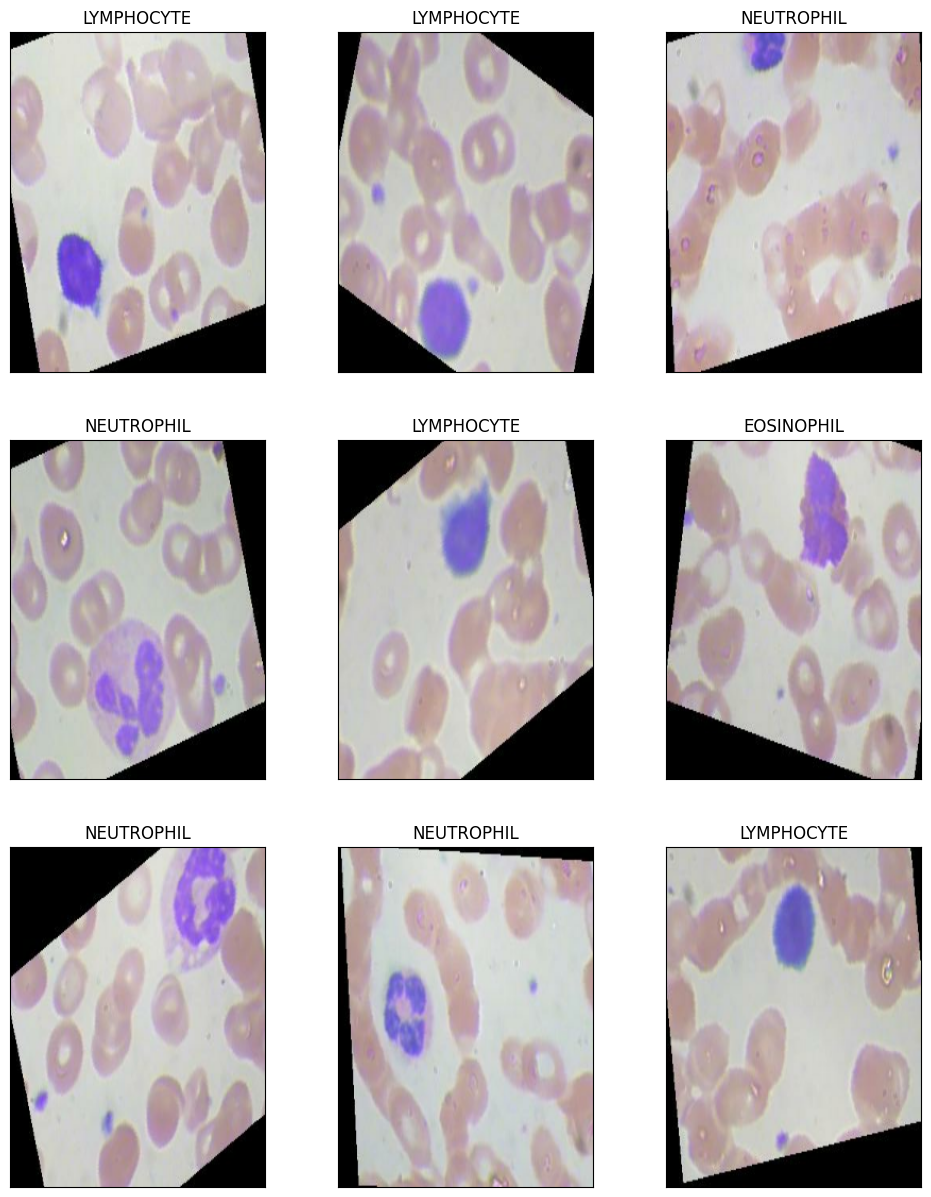

In [ ]:
# Plot 9 images from the dataset as examples
fig, ax = plt.subplots(3, 3, figsize=(12,15))
ax = ax.flat
for images, labels in learn_dataset.take(1):
  for i in range(9):
    ax[i].set_title(class_names[labels[i].numpy()])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(images[i].numpy().astype("uint8"))
plt.savefig("Examples.png", dpi=300)

In [ ]:
# Check format
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

Train data: (32, 320, 240, 3)
Train labels: (32,)


In [ ]:
for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

In [ ]:
for image_batch, labels_batch in test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

# **Models**

In [ ]:
# Create a lab-book to track the different experiments
lab_book = {}

In [ ]:
#Create a callback to stop fit step before the end if the monitor is reached
earlystopping = EarlyStopping(monitor='val_accuracy',mode = 'max', patience = 5, verbose = 1, restore_best_weights=True)

## **Custom CNN model**
Based of "[A Novel Architecture to Classify Histopathology Images Using Convolutional Neural Networks](https://www.mdpi.com/2076-3417/10/8/2929)"

Based on the obtained results, two main points are recommended:
*    Try **different activation functions** and to fully analyze their impact other than choosing the ReLU activation function as a default.
*    Place the **normalization layer before the activation** function

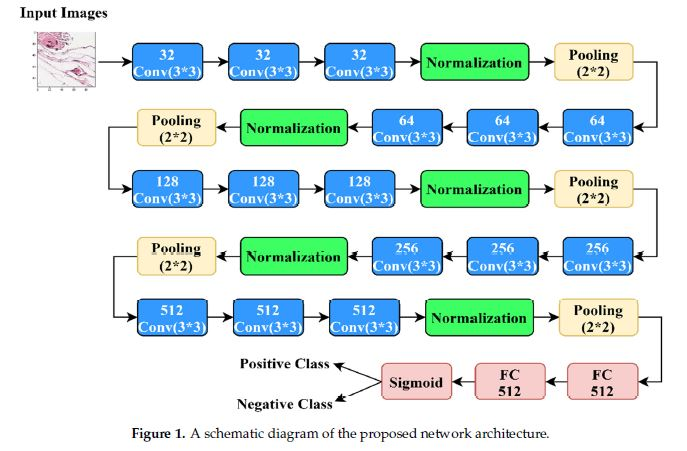

In [ ]:
# List of activation function based on the article
activ_fn=['relu','elu','leaky_relu','selu','tanh']

# List of optimizers
opt=['rmsprop', 'Adam', 'SGD']

### Model 1
* No drop out layers in classifier block
* Activation = eLu
* Optimizer = ADAM

In [ ]:
custom_cnn1 = Sequential()

#Input
custom_cnn1.add(Input(shape=(img_height, img_width, 3)))

#Rescaling
custom_cnn1.add(Rescaling(1./255))

#First convolutionnal block
custom_cnn1.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn1.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn1.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn1.add(BatchNormalization())
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(MaxPooling2D(pool_size = 2))

#Second convolutionnal block
custom_cnn1.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn1.add(BatchNormalization())
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(MaxPooling2D(pool_size = 3))

#Third convolutionnal block
custom_cnn1.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn1.add(BatchNormalization())
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(MaxPooling2D(pool_size = 3))

#Fourth convolutionnal block
custom_cnn1.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn1.add(BatchNormalization())
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(MaxPooling2D(pool_size = 3))

#Fifth convolutionnal block
custom_cnn1.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn1.add(BatchNormalization())
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(MaxPooling2D(pool_size = 2))

#Flatten block
custom_cnn1.add(Flatten())

#Classifier block without dropout
custom_cnn1.add(Dense(512))
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(Dense(512))
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(Dense(num_classes, activation = 'softmax'))

In [ ]:
custom_cnn1.summary()

In [ ]:
# Compile the model with adam optimizer
name='model_1'
custom_cnn1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Defining specific Model Checkpoint (we will use already defined EarlyStopping "earlystopping" )
checkpoint = ModelCheckpoint(filepath='chkpt_model_1', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [ ]:
# Train the model
custom_cnn1.fit(train_dataset, validation_data=val_dataset,
          epochs=epochs, batch_size=batch_size, verbose=1, callbacks = [earlystopping, checkpoint])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 1.4519 - accuracy: 0.4386
Epoch 1: val_accuracy improved from -inf to 0.24925, saving model to chkpt_model_1
250/250 [==============================] - 625s 2s/step - loss: 1.4519 - accuracy: 0.4386 - val_loss: 5.8055 - val_accuracy: 0.2493
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 1.0256 - accuracy: 0.5391
Epoch 2: val_accuracy improved from 0.24925 to 0.43071, saving model to chkpt_model_1
250/250 [==============================] - 88s 353ms/step - loss: 1.0256 - accuracy: 0.5391 - val_loss: 2.1269 - val_accuracy: 0.4307
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.9123 - accuracy: 0.6047
Epoch 3: val_accuracy did not improve from 0.43071
250/250 [==============================] - 86s 344ms/step - loss: 0.9123 - accuracy: 0.6047 - val_loss: 1.6233 - val_accuracy: 0.4177
Epoch 4/25
250/250 [==============================] - ETA: 0s - loss: 0.8468 - accuracy: 0.6

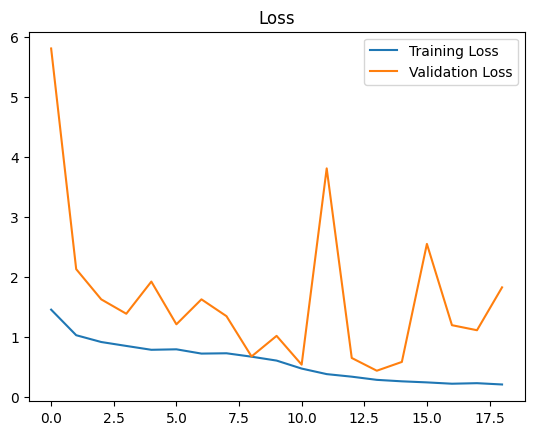

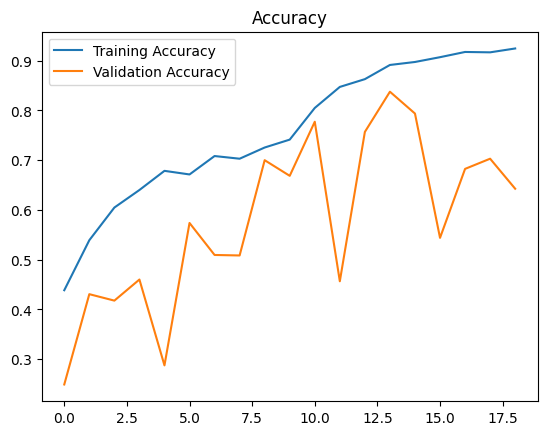

In [ ]:
history_cnn1 = custom_cnn1.history.history

train_loss = history_cnn1['loss']
val_loss = history_cnn1['val_loss']
train_acc = history_cnn1['accuracy']
val_acc = history_cnn1['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Write lab-book
train_accuracy = custom_cnn1.evaluate(train_dataset)[1]
val_accuracy = custom_cnn1.evaluate(val_dataset)[1]
test_accuracy = custom_cnn1.evaluate(test_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 212s 3s/step - loss: 0.4523 - accuracy: 0.8393


In [ ]:
# Save model
custom_cnn1.save("model_1.keras")

In [ ]:
preds = custom_cnn1.predict(test_dataset)  # Running model on the validation dataset
test_loss, test_acc = custom_cnn1.evaluate(test_dataset) # Obtaining Loss and Accuracy on the val dataset

print('\nTest Loss: ', test_loss)
print('\nTest Accuracy: ', np.round(test_acc * 100), '%')

--------------------
### Model 2
* No drop out layers in classifier block
* Activation = eLu
* Optimizer = RMSProp


In [ ]:
custom_cnn2 = Sequential()

custom_cnn2.add(Input(shape=(img_height, img_width, 3)))

#Rescaling
custom_cnn2.add(Rescaling(1./255))

#First convolutionnal block
custom_cnn2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn2.add(BatchNormalization())
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(MaxPooling2D(pool_size = 2))

#Second convolutionnal block
custom_cnn2.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn2.add(BatchNormalization())
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(MaxPooling2D(pool_size = 3))

#Third convolutionnal block
custom_cnn2.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn2.add(BatchNormalization())
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(MaxPooling2D(pool_size = 3))

#Fourth convolutionnal block
custom_cnn2.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn2.add(BatchNormalization())
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(MaxPooling2D(pool_size = 3))

#Fifth convolutionnal block
custom_cnn2.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn2.add(BatchNormalization())
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(MaxPooling2D(pool_size = 2))

#Flatten block
custom_cnn2.add(Flatten())

#Classifier block without dropout
custom_cnn2.add(Dense(512))
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(Dense(512))
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(Dense(num_classes, activation = 'softmax'))


In [ ]:
# Compile the model with rmsprop optimizer
name='model_2'
custom_cnn2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Creation of the checkpoint
checkpoint = ModelCheckpoint(filepath='chkpt_model_2', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [ ]:
# Train the model
custom_cnn2.fit(train_dataset, validation_data=val_dataset,
          epochs=epochs, batch_size=batch_size, verbose=1, callbacks = [earlystopping, checkpoint])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 2.0581 - accuracy: 0.2501
Epoch 1: val_accuracy improved from -inf to 0.26072, saving model to chkpt_model_2
250/250 [==============================] - 91s 350ms/step - loss: 2.0581 - accuracy: 0.2501 - val_loss: 1.6135 - val_accuracy: 0.2607
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 1.3421 - accuracy: 0.3445
Epoch 2: val_accuracy improved from 0.26072 to 0.33898, saving model to chkpt_model_2
250/250 [==============================] - 90s 358ms/step - loss: 1.3421 - accuracy: 0.3445 - val_loss: 2.2697 - val_accuracy: 0.3390
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.9881 - accuracy: 0.5336
Epoch 3: val_accuracy improved from 0.33898 to 0.36540, saving model to chkpt_model_2
250/250 [==============================] - 90s 358ms/step - loss: 0.9881 - accuracy: 0.5336 - val_loss: 1.8520 - val_accuracy: 0.3654
Epoch 4/25
250/250 [==============================] - E

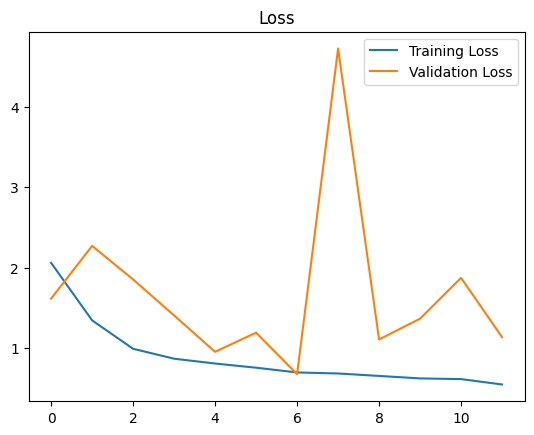

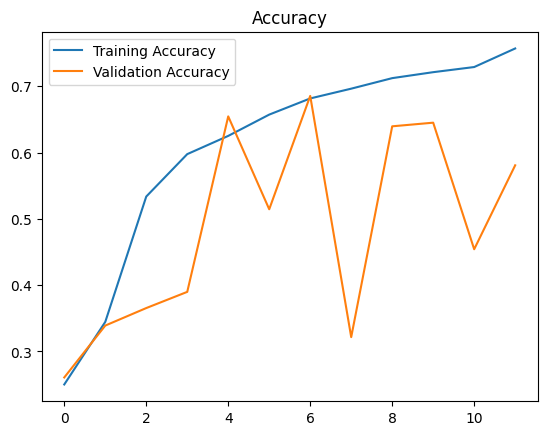

In [ ]:
history_cnn2 = custom_cnn2.history.history

train_loss = history_cnn2['loss']
val_loss = history_cnn2['val_loss']
train_acc = history_cnn2['accuracy']
val_acc = history_cnn2['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Write lab-book
train_accuracy = custom_cnn2.evaluate(train_dataset)[1]
val_accuracy = custom_cnn2.evaluate(val_dataset)[1]
test_accuracy = custom_cnn2.evaluate(test_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 7s 92ms/step - loss: 0.6563 - accuracy: 0.6977


In [ ]:
# Save model
custom_cnn2.save("model_2.keras")

### Model 3
* No drop out layers in classifier block
* Activation = eLu
* Optimizer = SGD

In [ ]:
# Compile the model with SGD optimizer + ELU
name='model_3'

custom_cnn1.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Creation of the checkpoint
checkpoint = ModelCheckpoint(filepath='chkpt_model_3', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [ ]:
# Train the model
custom_cnn1.fit(train_dataset, validation_data=val_dataset,
          epochs=epochs, batch_size=batch_size, verbose=1, callbacks = [earlystopping, checkpoint])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9354
Epoch 1: val_accuracy improved from -inf to 0.33848, saving model to chkpt_model_3
250/250 [==============================] - 90s 361ms/step - loss: 0.1637 - accuracy: 0.9354 - val_loss: 8.7112 - val_accuracy: 0.3385
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9419
Epoch 2: val_accuracy improved from 0.33848 to 0.88285, saving model to chkpt_model_3
250/250 [==============================] - 90s 358ms/step - loss: 0.1525 - accuracy: 0.9419 - val_loss: 0.3074 - val_accuracy: 0.8829
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9376
Epoch 3: val_accuracy improved from 0.88285 to 0.92871, saving model to chkpt_model_3
250/250 [==============================] - 89s 356ms/step - loss: 0.1549 - accuracy: 0.9376 - val_loss: 0.1924 - val_accuracy: 0.9287
Epoch 4/25
250/250 [==============================] - E

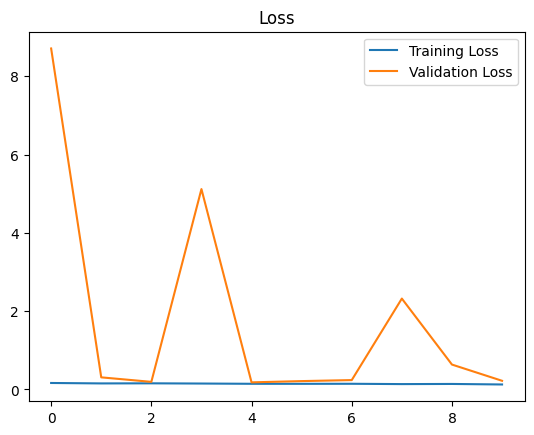

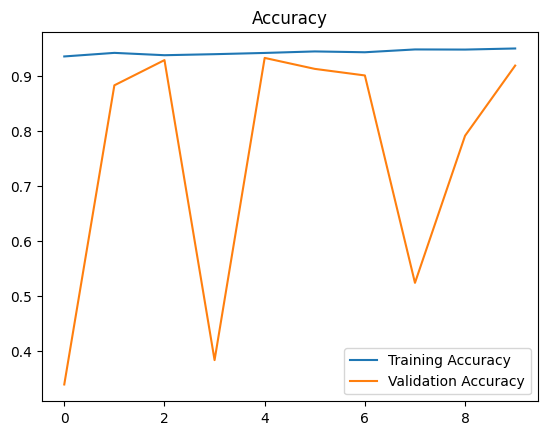

In [ ]:
history_cnn3 = custom_cnn1.history.history

train_loss = history_cnn3['loss']
val_loss = history_cnn3['val_loss']
train_acc = history_cnn3['accuracy']
val_acc = history_cnn3['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Write lab-book
train_accuracy = custom_cnn1.evaluate(train_dataset)[1]
val_accuracy = custom_cnn1.evaluate(val_dataset)[1]
test_accuracy = custom_cnn1.evaluate(test_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 7s 92ms/step - loss: 0.1973 - accuracy: 0.9252


In [ ]:
# Save model
custom_cnn1.save("model_3.keras")

### Model 4
* 2 drop out layers in classifier block
* Activation = eLu
* Optimizer = SGD

In [ ]:
name='model_4'

custom_cnn4 = Sequential()

custom_cnn4.add(Input(shape=(img_height, img_width, 3)))

#Rescaling
custom_cnn4.add(Rescaling(1./255))

#First convolutionnal block
custom_cnn4.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn4.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn4.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn4.add(BatchNormalization())
custom_cnn4.add(Activation('elu'))
custom_cnn4.add(MaxPooling2D(pool_size = 2))

#Second convolutionnal block
custom_cnn4.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn4.add(BatchNormalization())
custom_cnn4.add(Activation('elu'))
custom_cnn4.add(MaxPooling2D(pool_size = 3))

#Third convolutionnal block
custom_cnn4.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn4.add(BatchNormalization())
custom_cnn4.add(Activation('elu'))
custom_cnn4.add(MaxPooling2D(pool_size = 3))

#Fourth convolutionnal block
custom_cnn4.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn4.add(BatchNormalization())
custom_cnn4.add(Activation('elu'))
custom_cnn4.add(MaxPooling2D(pool_size = 3))

#Fifth convolutionnal block
custom_cnn4.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn4.add(BatchNormalization())
custom_cnn4.add(Activation('elu'))
custom_cnn4.add(MaxPooling2D(pool_size = 2))

#Flatten block
custom_cnn4.add(Flatten())

#Classifier block with dropout
custom_cnn4.add(Dense(512, activation='elu'))
custom_cnn4.add(Dropout(0.3))
custom_cnn4.add(Dense(512, activation = 'elu'))
custom_cnn4.add(Dropout(0.3))
custom_cnn4.add(Dense(num_classes, activation = 'softmax'))


In [ ]:
# Compile the model with SGD optimizer
custom_cnn4.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Creation of the checkpoint
checkpoint = ModelCheckpoint(filepath='chkpt_model_4', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [ ]:
# Train the model
custom_cnn4.fit(train_dataset, validation_data=val_dataset,
          epochs=epochs, batch_size=batch_size, verbose=1, callbacks = [earlystopping, checkpoint])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 1.4701 - accuracy: 0.4279
Epoch 1: val_accuracy improved from -inf to 0.38036, saving model to chkpt_model_4
250/250 [==============================] - 93s 359ms/step - loss: 1.4701 - accuracy: 0.4279 - val_loss: 1.4940 - val_accuracy: 0.3804
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 0.7836 - accuracy: 0.6591
Epoch 2: val_accuracy did not improve from 0.38036
250/250 [==============================] - 87s 347ms/step - loss: 0.7836 - accuracy: 0.6591 - val_loss: 3.0859 - val_accuracy: 0.2617
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.5138 - accuracy: 0.7835
Epoch 3: val_accuracy did not improve from 0.38036
250/250 [==============================] - 86s 344ms/step - loss: 0.5138 - accuracy: 0.7835 - val_loss: 3.4215 - val_accuracy: 0.3420
Epoch 4/25
250/250 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8515
Epoch 4: val_accuracy improve

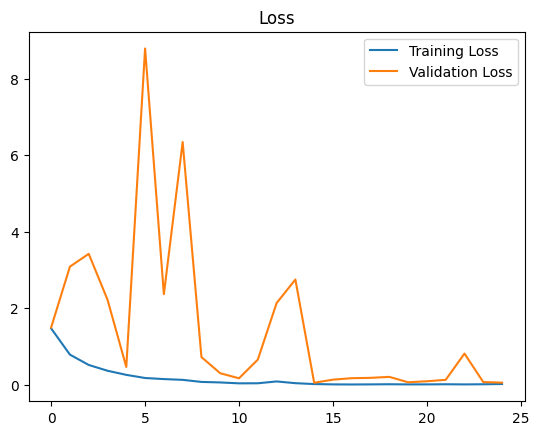

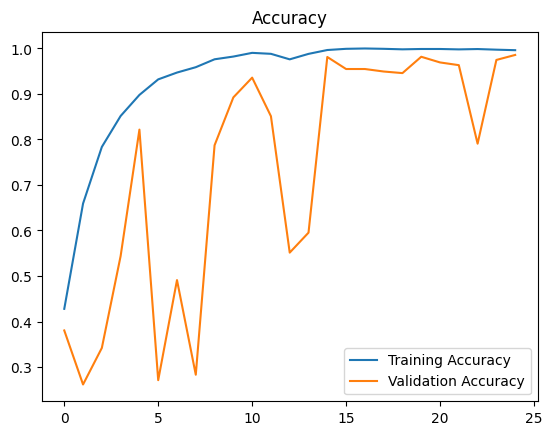

In [ ]:
history_cnn4 = custom_cnn4.history.history

train_loss = history_cnn4['loss']
val_loss = history_cnn4['val_loss']
train_acc = history_cnn4['accuracy']
val_acc = history_cnn4['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Write lab-book
train_accuracy = custom_cnn4.evaluate(train_dataset)[1]
val_accuracy = custom_cnn4.evaluate(val_dataset)[1]
test_accuracy = custom_cnn4.evaluate(test_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 7s 92ms/step - loss: 0.0807 - accuracy: 0.9756


In [ ]:
# Save model
custom_cnn4.save("model_4.keras")

## **ResNet architecture**

In [ ]:
# Prepare data for ResNet50 input
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

train_dataset_resnet = train_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)
val_dataset_resnet = val_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)
test_dataset_resnet = test_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check format
for image_batch, labels_batch in train_dataset_resnet.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset_resnet.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in test_dataset_resnet.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 240, 180, 3)
Train labels: (32,)
Validation data: (32, 240, 180, 3)
Validation labels: (32,)
Test data: (32, 240, 180, 3)
Test labels: (32,)


### Model 5 - Feature extraction with ResNet50

The ResNet50 model is used to extract features. To do this, the datasets must be transformed to meet the requirements of this model.

In [ ]:
# Name the model
name = "model_5"

# Download the pretrained resnet model and save it as a layer
res_model = ResNet50(include_top=False,
                                    input_shape=(img_height, img_width, 3))

# Freeze all layers of base model
res_model.trainable = False

# Build model
model_resnet1 = keras.Sequential([res_model,
                            layers.GlobalAvgPool2D(),
                            layers.Dense(num_classes, activation="softmax")
                            ], name=name)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Compile model
model_resnet1.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])

In [ ]:
# Creation of the checkpoint
checkpoint = ModelCheckpoint(filepath='chkpt_model_5', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [ ]:
# Fit model
history_5 = model_resnet1.fit(train_dataset_resnet,
                        validation_data=val_dataset_resnet,
                        epochs=epochs,
                        callbacks=[earlystopping, checkpoint])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 1.7712 - accuracy: 0.4190
Epoch 1: val_accuracy improved from -inf to 0.36092, saving model to chkpt_model_5
250/250 [==============================] - 71s 267ms/step - loss: 1.7712 - accuracy: 0.4190 - val_loss: 1.6452 - val_accuracy: 0.3609
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 1.2271 - accuracy: 0.5548
Epoch 2: val_accuracy improved from 0.36092 to 0.56879, saving model to chkpt_model_5
250/250 [==============================] - 66s 262ms/step - loss: 1.2271 - accuracy: 0.5548 - val_loss: 1.2247 - val_accuracy: 0.5688
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.9010 - accuracy: 0.6438
Epoch 3: val_accuracy improved from 0.56879 to 0.70887, saving model to chkpt_model_5
250/250 [==============================] - 65s 257ms/step - loss: 0.9010 - accuracy: 0.6438 - val_loss: 0.7196 - val_accuracy: 0.7089
Epoch 4/25
250/250 [==============================] - E

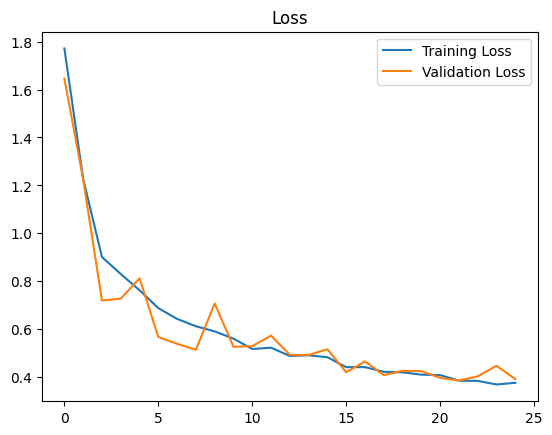

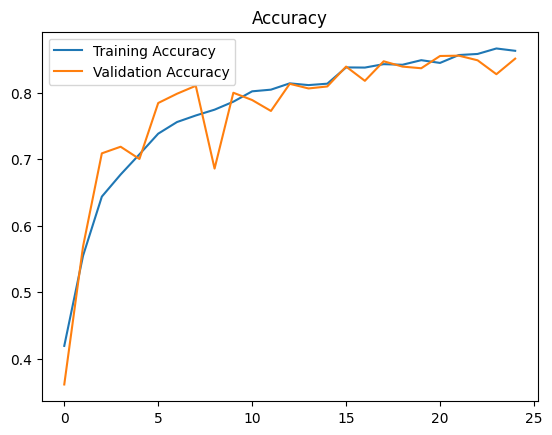

In [ ]:
history_res1 = model_resnet1.history.history

train_loss = history_res1['loss']
val_loss = history_res1['val_loss']
train_acc = history_res1['accuracy']
val_acc = history_res1['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Write lab-book
train_accuracy = model_resnet1.evaluate(train_dataset_resnet)[1]
val_accuracy = model_resnet1.evaluate(val_dataset_resnet)[1]
test_accuracy = model_resnet1.evaluate(test_dataset_resnet)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 12s 148ms/step - loss: 0.3766 - accuracy: 0.8561


In [ ]:
# Save model
model_resnet1.save("model_5.keras")

### Model 6 - Transfer learning with ResNet50 (partial training)
The same architecture as in previous one, but this time the ResNet50 base model is partially unfrozen. We ‘freeze’ all layers except for the last block of the ResNet50 that will be trained

In [ ]:
# Name the model
name = "model_6"

# Freeze all layers of base model except the last block
for layer in res_model.layers[144:]:
      layer.trainable = True
# Check the freezed was done ok
for i, layer in enumerate(res_model.layers):
        print(i, layer.name, "-", layer.trainable)

0 input_5 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [ ]:
# Build model integrating the classifier block created in custom_cnn model
model_resnet2 = keras.Sequential([res_model,
                                  layers.Flatten(),
                                  layers.BatchNormalization(),
                                  layers.Dense(512, activation='relu'), #change the activation function?
                                  layers.Dropout(0.3),
                                  layers.Dense(512, activation = 'relu'), #change the activation function?
                                  layers.Dropout(0.3),
                                  layers.Dense(num_classes, activation='softmax')],name=name)

In [ ]:
# Compile model
model_resnet2.compile(loss='sparse_categorical_crossentropy',
                optimizer='sgd',
                metrics=["accuracy"])

In [ ]:
# Creation of the checkpoint
checkpoint = ModelCheckpoint(filepath='chkpt_model_6', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [ ]:
# Fit model
history_6 = model_resnet2.fit(train_dataset_resnet,
                        validation_data=val_dataset_resnet,
                        epochs=30,
                        callbacks=[earlystopping, checkpoint])

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 1.0055 - accuracy: 0.6398
Epoch 1: val_accuracy improved from -inf to 0.84646, saving model to chkpt_model_6
250/250 [==============================] - 79s 299ms/step - loss: 1.0055 - accuracy: 0.6398 - val_loss: 0.3950 - val_accuracy: 0.8465
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9283
Epoch 2: val_accuracy improved from 0.84646 to 0.88385, saving model to chkpt_model_6
250/250 [==============================] - 72s 287ms/step - loss: 0.1975 - accuracy: 0.9283 - val_loss: 0.2950 - val_accuracy: 0.8838
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9684
Epoch 3: val_accuracy improved from 0.88385 to 0.91176, saving model to chkpt_model_6
250/250 [==============================] - 74s 297ms/step - loss: 0.0844 - accuracy: 0.9684 - val_loss: 0.2380 - val_accuracy: 0.9118
Epoch 4/30
250/250 [==============================] - E

In [ ]:
history_res2 = model_resnet2.history.history

train_loss = history_res2['loss']
val_loss = history_res2['val_loss']
train_acc = history_res2['accuracy']
val_acc = history_res2['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Write lab-book
train_accuracy = model_resnet2.evaluate(train_dataset_resnet)[1]
val_accuracy = model_resnet2.evaluate(val_dataset_resnet)[1]
test_accuracy = model_resnet2.evaluate(test_dataset_resnet)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 11s 142ms/step - loss: 0.2817 - accuracy: 0.9156


In [ ]:
# Save model
model_resnet2.save("model_6.keras")

### Model 7 - Transfer learning with ResNet50 (full training)
The same architecture as in previous one, but this time the ResNet50 base model is **fully** unfrozen to be trained.

In [ ]:
# Unfreeze all layers of base model
res_model.trainable = True

In [ ]:
name = "model_7"

model_resnet3 = keras.Sequential([res_model,
                                  layers.Flatten(),
                                  layers.BatchNormalization(),
                                  layers.Dense(512, activation='relu'), #change the activation function?
                                  layers.Dropout(0.3),
                                  layers.Dense(512, activation = 'relu'), #change the activation function?
                                  layers.Dropout(0.3),
                                  layers.Dense(num_classes, activation='softmax')],name=name)

In [ ]:
# Compile model
model_resnet3.compile(loss='sparse_categorical_crossentropy',
                optimizer='sgd',
                metrics=["accuracy"])

In [ ]:
# Creation of the checkpoint
checkpoint = ModelCheckpoint(filepath='chkpt_model_7', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [ ]:
# Fit model
history_7 = model_resnet3.fit(train_dataset_resnet,
                        validation_data=val_dataset_resnet,
                        epochs=epochs,
                        callbacks=[earlystopping, checkpoint])

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.6020 - accuracy: 0.7921
Epoch 1: val_accuracy improved from -inf to 0.94566, saving model to chkpt_model_7
250/250 [==============================] - 178s 641ms/step - loss: 0.6020 - accuracy: 0.7921 - val_loss: 0.1469 - val_accuracy: 0.9457
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.1053 - accuracy: 0.9620
Epoch 2: val_accuracy did not improve from 0.94566
250/250 [==============================] - 134s 536ms/step - loss: 0.1053 - accuracy: 0.9620 - val_loss: 0.2086 - val_accuracy: 0.9227
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.9879
Epoch 3: val_accuracy improved from 0.94566 to 0.98704, saving model to chkpt_model_7
250/250 [==============================] - 157s 628ms/step - loss: 0.0395 - accuracy: 0.9879 - val_loss: 0.0504 - val_accuracy: 0.9870
Epoch 4/30
250/250 [==============================] - ETA: 0s - loss: 0.0179 - accuracy

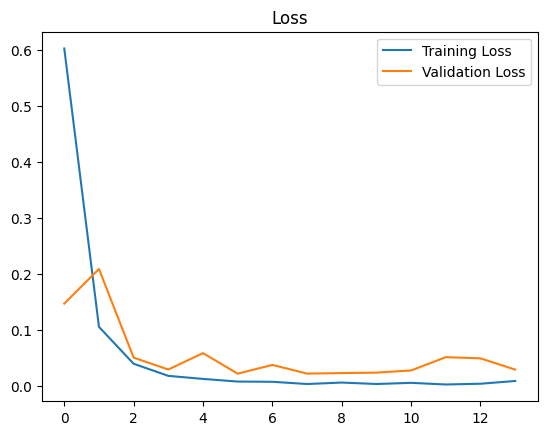

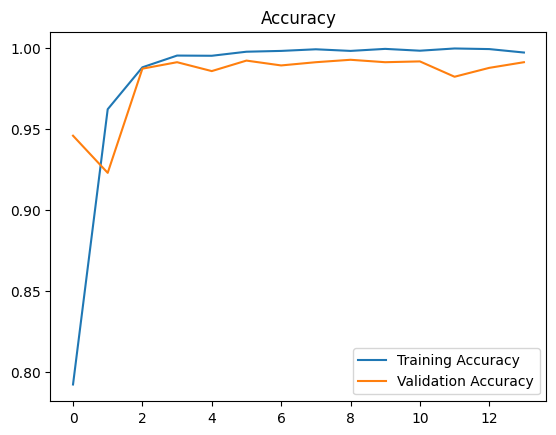

In [ ]:
history_res3 = model_resnet3.history.history

train_loss = history_res3['loss']
val_loss = history_res3['val_loss']
train_acc = history_res3['accuracy']
val_acc = history_res3['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Write lab-book
train_accuracy = model_resnet3.evaluate(train_dataset_resnet)[1]
val_accuracy = model_resnet3.evaluate(val_dataset_resnet)[1]
test_accuracy = model_resnet3.evaluate(test_dataset_resnet)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 11s 142ms/step - loss: 0.0156 - accuracy: 0.9932


In [ ]:
# Save model
model_resnet3.save("model_7.keras")

### (TBC) Model 8 - Transfer learning with ResNet50 (full training)
The same architecture as in previous one, but this time the ResNet50 base model is **fully** unfrozen to be trained.

In [ ]:
# Build model integrating the classifier block created in custom_cnn model
# Name the model
name = "model_8"

model_resnet3_relu = keras.Sequential([res_model,
                                  layers.Flatten(),
                                  layers.BatchNormalization(),
                                  layers.Dense(512, activation='relu'), #change the activation function?
                                  layers.Dropout(0.3),
                                  layers.Dense(512, activation = 'relu'), #change the activation function?
                                  layers.Dropout(0.3),
                                  layers.Dense(num_classes, activation='softmax')],name=name)


# Compile model
model_resnet3_relu.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt[1],
                metrics=["accuracy"])

# Fit model
history_9 = model_resnet3_relu.fit(train_dataset_resnet,
                        validation_data=val_dataset_resnet,
                        epochs=30,
                        callbacks=[earlystopping])

In [ ]:
# Write lab-book
train_accuracy = model_resnet3_relu.evaluate(train_dataset_resnet)[1]
val_accuracy = model_resnet3_relu.evaluate(val_dataset_resnet)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy}

In [ ]:
# Check test set accuracy of ResNet50_model_2 since base model will be changed afterwards
test_scores = {}
test_accuracy = model_resnet3_relu.evaluate(test_dataset_resnet)[1]
test_scores["ResNet50_model_3"] = test_accuracy

## Models comparison

In [ ]:
# Compare accuracies of different models
df_acc = pd.DataFrame(lab_book).transpose()
df_acc

,train_accuracy,val_accuracy,test_accuracy
model_1,0.853375,0.837488,0.839264
model_2,0.716750,0.683450,0.697721
model_3,0.943375,0.929212,0.925230
model_4,0.999875,0.985543,0.975610
model_5,0.890250,0.851944,0.856058
Model_6,1.000000,0.932702,0.915634
model_7,1.000000,0.992522,0.993203


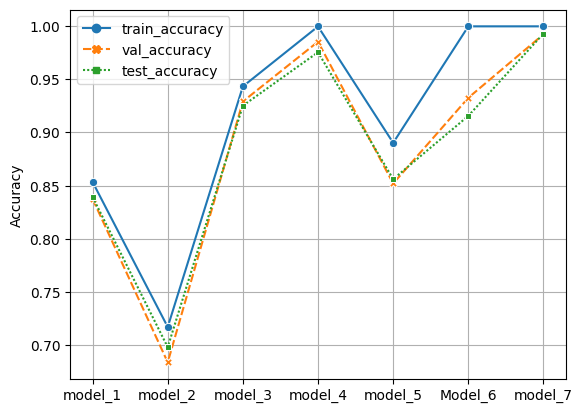

In [ ]:
# Plot accuracies against models
sns.lineplot(data=df_acc, markers=True)
plt.grid()
plt.ylabel("Accuracy")
plt.savefig("Accuracy plot.png", dpi=300)
plt.show()